In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import json
sns.set_context("notebook")

In [2]:
def load_sweep(path: str) -> pd.DataFrame:
    with open(path) as f:
        return pd.DataFrame.from_dict(
            dict(**line, **result)
            for line in filter(lambda d: "results" in d, map(json.loads, f))
            for result in line["results"]
        ).drop(columns=["results", "_duration"])

(pd.concat([load_sweep(f) for f in Path("data").glob("*.jsonl")]).reset_index(drop=True)
    .drop(columns=["question_id", "output", "id", "local_ratio"])
    .groupby(["dataset", "shots", "model_scale", "sparsity", "k"], dropna=False).mean()
    .reset_index()
    .to_json("summary.json")
)

In [3]:
df = (pd.read_json("summary.json")
    .pipe(lambda d: d.assign(score=np.where(d.match.isna(), d.rougeL, d.match.astype("float"))))
)

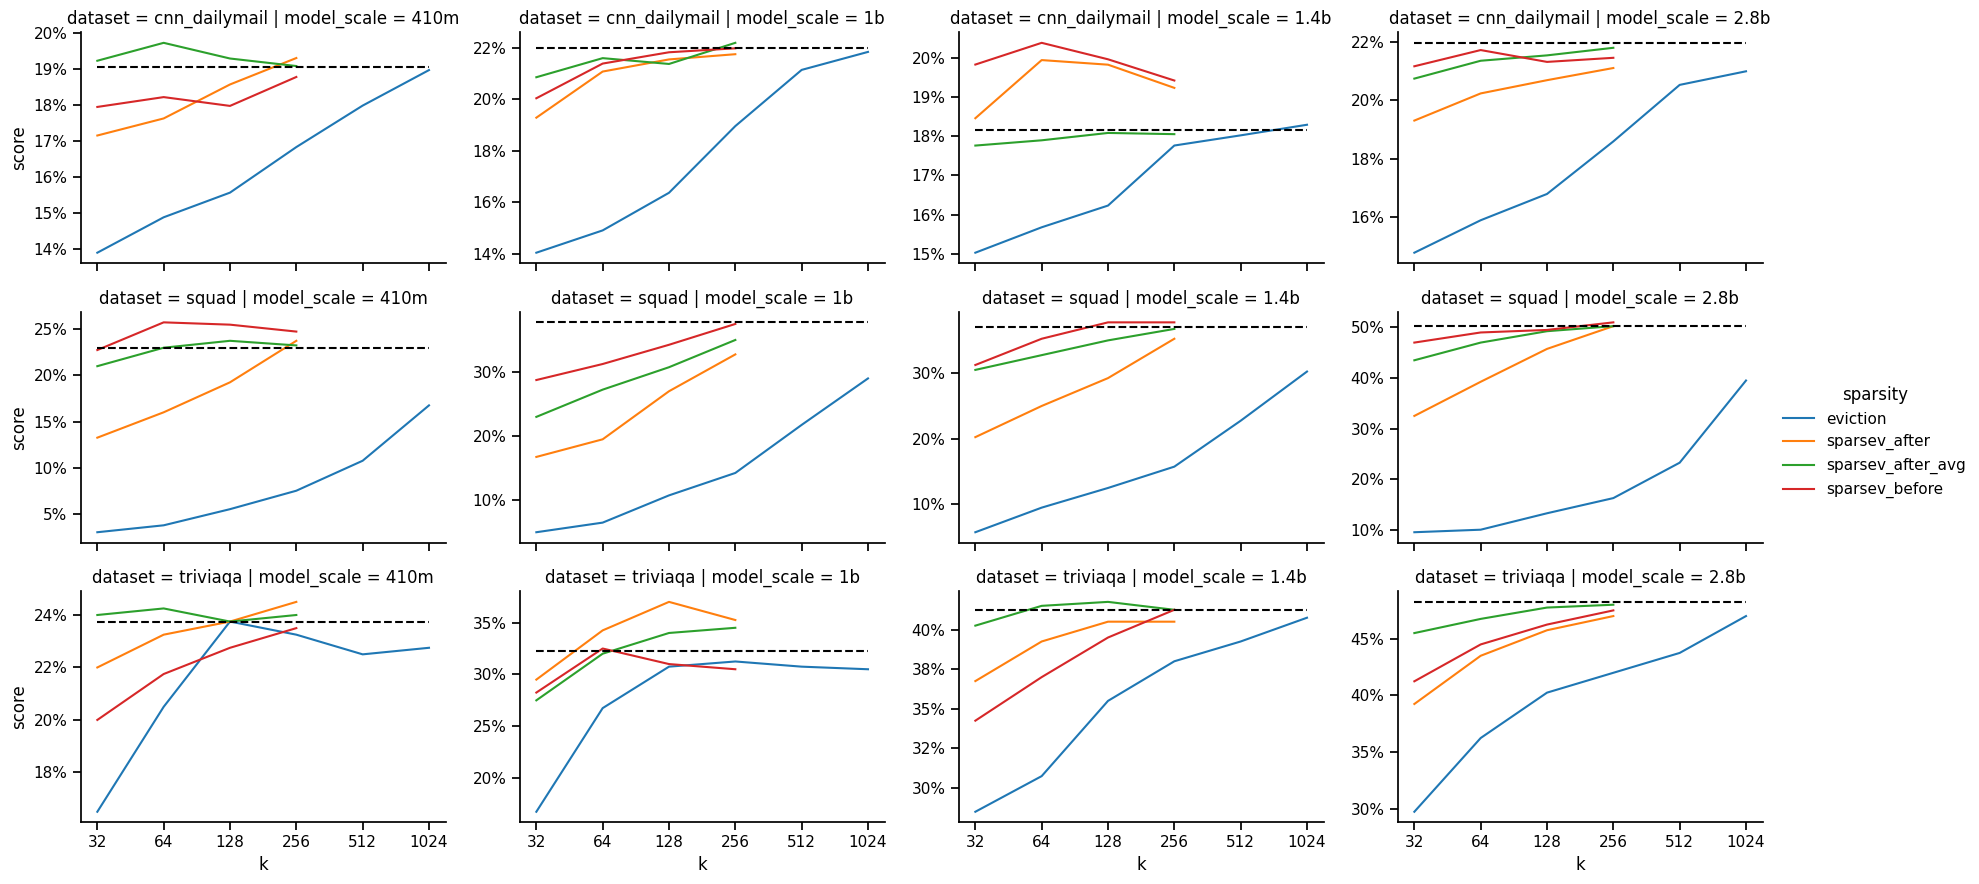

In [4]:
def get_name(s: pd.Series) -> str:
    if str(s.sparsity) == "eviction":
        return f"eviction + local({100*s.local_ratio:.0f}%)"
    return s.sparsity

d = df.pipe(lambda d: d[d.model_scale != "160m"])

g = sns.relplot(data=d.pipe(lambda d: d[d.sparsity != "none"]),
                y="score", x="k", hue="sparsity", row="dataset", col="model_scale",
                col_order=["410m", "1b", "1.4b", "2.8b"], kind="line", facet_kws=dict(sharey=False), height=3, aspect=1.5)
for (dataset, model_scale), d in d.pipe(lambda d: d[d.sparsity == "none"]).groupby(["dataset", "model_scale"]):
    ax = g.axes_dict[(dataset, model_scale)]
    ax.hlines(d.score, 32, 1024, "k", linestyle="dashed", label="dense baseline")
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    if model_scale == "160m":
        ax.set_ylabel("RougeL F-score" if dataset == "cnn_dailymail" else "Accuracy")